# Sentiment Analysis using word vector and ConvNet in Keras

In [1]:
# CONFIGS

# The word vector can be swapped with say GoogleNews 6B dataset
word_vector_bin_file = "word2vec/model-0.bin"
# word_vector_bin_file = "word2vec/GoogleNews-vectors-negative300.bin"
# word_vector_bin_file = "model-0.bin"
word_vector_dims = 100

# in aclImdb, the longest review is 2470 words long
# Due to memory constraint, in this one I limit to 200 words
max_sentence_length = 200

# Can easily swap with other datasets if you want
positive_review_txts = "aclImdb/train/pos/*.txt"
negative_review_txts = "aclImdb/train/neg/*.txt"
positive_review_vals = "aclImdb/test/pos/*.txt"
negative_review_vals = "aclImdb/test/neg/*.txt"
# positive_review_txts = "polarity2/txt_sentoken/pos/*.txt"
# negative_review_txts = "polarity2/txt_sentoken/neg/*.txt"
# positive_review_vals = "polarity2/txt_sentoken/pos/*.txt"
# negative_review_vals = "polarity2/txt_sentoken/neg/*.txt"

# Test theano and graphics card
import theano.tensor as T

# Notebook
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

Using gpu device 0: GeForce GTX 1060 6GB (CNMeM is disabled, cuDNN 5105)
/home/anonoz/anaconda2/envs/tensorflow/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


## Step 1: Make X_train

X_train data structure is a 3D array, consisting of reviews, words, and vectors:
```json
[
  // a review
  [
    // a word, and its array of 100 vectors
    [0.75, 0.64 ...],
    ...
  ], 
  ...
]
```

### TODO:
1. Load all the reviews into memory
2. Normalize the text
3. Add words to vocab array to make word vector retrieval faster
3. Determine vocab size, max review length

In [2]:
from bs4 import BeautifulSoup  
import re

def normalise_text(text):
    # Step 0: Clean HTML tags
    normalised_text = BeautifulSoup(text, "html.parser").get_text()
    
    # Step 1: Lower cap
    normalised_text = normalised_text.lower()
    
    # Step 2: Leave only abc behind
    normalised_text = re.sub("[^a-zA-Z ]", " ", normalised_text)
    
    # Step 3: 
    return normalised_text

# Test normalise_text
print(normalise_text("OMG <br/><br />this is soo00.... funny!!!"))

def raw_to_array(review_text):
    return normalise_text(review_text).split()

# Test both fx above
print(raw_to_array("OMG <br/><br />this is soo00.... funny!!!"))

omg this is soo       funny   
[u'omg', u'this', u'is', u'soo', u'funny']


('highest word count: ', 2487)
[u'i', u'remember', u'watching', u'this', u'late', u'at', u'night', u'on', u'black', u'and', u'white', u'tv', u'long', u'before', u'a', u'live', u'action', u'version', u'was', u'so']
('mean of review length: ', 236.82848000000001)


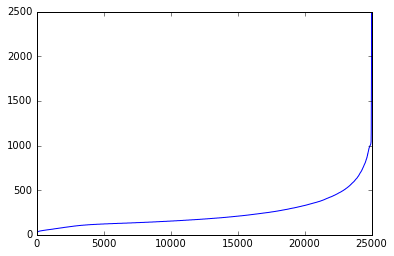

In [3]:
import glob

# highest word count shall be the convnet rows
highest_review_word_count = 0
positive_reviews = []
negative_reviews = []
positive_testrev = []
negative_testrev = []

# to visualise review length
training_review_length = []

for txt in glob.glob(positive_review_txts):
    with (open(txt, 'r')) as f:
        word_array = raw_to_array(f.read())
        highest_review_word_count = max(highest_review_word_count, len(word_array))
        positive_reviews.append(word_array)
        training_review_length.append(len(word_array))

for txt in glob.glob(negative_review_txts):
    with (open(txt, 'r')) as f:
        word_array = raw_to_array(f.read())
        highest_review_word_count = max(highest_review_word_count, len(word_array))
        negative_reviews.append(raw_to_array(f.read()))
        training_review_length.append(len(word_array))
        
# For validation purposes
for txt in glob.glob(positive_review_vals):
    with (open(txt, 'r')) as f:
        word_array = raw_to_array(f.read())
        highest_review_word_count = max(highest_review_word_count, len(word_array))
        positive_testrev.append(word_array)

for txt in glob.glob(negative_review_vals):
    with (open(txt, 'r')) as f:
        word_array = raw_to_array(f.read())
        highest_review_word_count = max(highest_review_word_count, len(word_array))
        negative_testrev.append(raw_to_array(f.read()))
        

print('highest word count: ', highest_review_word_count)
print(positive_reviews[0][:20])

# Plotting length
training_review_length = np.sort(np.array(training_review_length))
print('mean of review length: ', np.mean(training_review_length))
plt.plot(training_review_length)

## Step 2: Assign vector to vocabs

In [4]:
from collections import defaultdict

vocab = defaultdict(float)
for review in positive_reviews + negative_reviews + positive_testrev + negative_testrev:
    for word in review:
        vocab[word] += 1
        
print("Vocab size: ", len(vocab))

('Vocab size: ', 75077)


In [5]:
import sys
word_vecs = {}
vocab_hit = 0

# Code copies from yoonkim CNN's process_data.py
with open(word_vector_bin_file, 'rb') as f:
    header = f.readline()
    vocab_size, layer1_size = map(int, header.split())
    print(['vocab_size', vocab_size], ['layer1_size', layer1_size])
#     word_vector_dims = layer1_size
    binary_len = np.dtype('float32').itemsize * layer1_size
    for line in range(vocab_size):
        word = []
        while True:
            ch = f.read(1)
            if ch == ' ':
                word = ''.join(word).lower()
                break
            if ch != '\n':
                word.append(ch)
        if word in vocab:
            word_vecs[word] = np.fromstring(f.read(binary_len), dtype='float32')
            vocab_hit += 1
        else:
            f.read(binary_len)

print('vocab hit: ', vocab_hit)

(['vocab_size', 116046], ['layer1_size', 100])
('vocab hit: ', 58744)


In [6]:
print(word_vecs['awesome'])

[ 0.20345445 -0.3446292  -0.79000551  0.50081944  0.44940072 -0.06276506
 -0.22317918 -0.25703317 -0.12849531 -0.31195965 -0.5679732   0.15336281
 -0.27494311  0.20641154 -0.37620348 -0.18761899 -0.02728397  0.1838602
  0.47868598 -0.49992049 -0.15919879  0.36610898 -0.26038209  0.11431786
 -0.00538804  0.33008578 -0.26670018  0.08674013 -0.55320936 -0.13692944
  0.21666591  0.1827794   0.26853284  0.17944637  0.63986886 -0.23207539
  0.13950627 -0.25690758  0.8048203  -0.22281611 -0.30845243  0.40280464
 -0.09700917 -0.10624079 -0.63829452  0.06724913  0.58268034  0.71300983
  0.21445699  0.07173178 -0.10021135  0.052795    0.21011689  0.55990034
  0.3317692  -0.1204156   0.33604714 -0.1214296   0.06541372  0.11289533
 -0.33093852 -0.36012915  0.07092347 -0.05363626  0.05315193 -0.40072322
 -0.37435323  0.54634482  0.04995376  0.4135814   0.11987102  0.35045838
 -0.22226219 -0.00525038  0.23082729  0.25800541  0.19155909 -0.05843235
 -0.24793234  0.16106944  0.21992229 -0.36523741 -0.

In [7]:
# Check if there are words missing from vector 
# (may happen if we use other word vectors than the one we trained)
missing_vocabs = []
for word in vocab:
    if word not in word_vecs and vocab[word] >= 1:
        word_vecs[word] = np.random.uniform(-0.25, 0.25, word_vector_dims)
        missing_vocabs.append(word)

print('missing vocabs: ', missing_vocabs[:20])

('missing vocabs: ', [u'tsukino', u'natilie', u'nordisk', u'happeningb', u'hmoney', u'sangreal', u'bedknob', u'gabreil', u'remendados', u'umte', u'bocka', u'enchelada', u'spracht', u'rumbustious', u'familiarness', u'bendar', u'macmurphy', u'donger', u'bendan', u'vibrational'])


In [8]:
total_reviews = len(positive_reviews) + len(negative_reviews)
max_test = 12500

X_train = []
Y_train = []
X_test  = []
Y_test  = []

# Due to memory constraint, we only take vectors for first 200 words in movie reviews
for i, review in enumerate(positive_reviews):
#     word_vector_array = np.ndarray(shape=(max_sentence_length, word_vector_dims), dtype='float32')
    word_vector_array = np.full((max_sentence_length, word_vector_dims), 0, dtype='float32')
    for j, word in enumerate(review):
        word_vector_array[j] = word_vecs[word][:word_vector_dims]
        if j == max_sentence_length -1:
            break
    X_train.append(word_vector_array)
    Y_train.append([0, 1])
    
for i, review in enumerate(negative_reviews):
    word_vector_array = np.full((max_sentence_length, word_vector_dims), 0, dtype='float32')
    for j, word in enumerate(review):
        word_vector_array[j] = word_vecs[word][:word_vector_dims]
        if j == max_sentence_length - 1:
            break
    X_train.append(word_vector_array)
    Y_train.append([1, 0])
    
# For validation purposes
for i, review in enumerate(positive_testrev):
    word_vector_array = np.full((max_sentence_length, word_vector_dims), 0, dtype='float32')
    for j, word in enumerate(review):
        word_vector_array[j] = word_vecs[word][:word_vector_dims]
        if j == max_sentence_length -1:
            break
    X_test.append(word_vector_array)
    Y_test.append([0, 1])
    if i == max_test:
        break
    
for i, review in enumerate(negative_testrev):
    word_vector_array = np.full((max_sentence_length, word_vector_dims), 0, dtype='float32')
    for j, word in enumerate(review):
        word_vector_array[j] = word_vecs[word][:word_vector_dims]
        if j == max_sentence_length - 1:
            break
    X_test.append(word_vector_array)
    Y_test.append([1, 0])
    if i == max_test:
        break

# print(X_train[0][0][100])
# print(Y_train[0].shape)

X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_test  = np.array(X_test)
Y_test  = np.array(Y_test)

In [9]:
print(X_train.shape)
print(Y_train.shape)

(25000, 200, 100)
(25000, 2)


## Step 3: Keras

![YoonKim CNN Architecture](yoonkim-cnn-architecture.png)

In [10]:
from keras.models import Model, Sequential
from keras.layers.convolutional import Convolution1D, Convolution2D
from keras.layers.pooling import MaxPooling1D, MaxPooling2D
from keras.layers import Merge, Dense, Dropout, Activation, Input, Flatten
from keras.optimizers import SGD

Using Theano backend.


In [11]:
# Based on the paper, there are filters of various sizes
filters = 150
epochs = 5

layer1_filter_sizes = [3,4,5]
layer1_convs = []

graph_in = Input(shape=(max_sentence_length, word_vector_dims))

for filter_size in layer1_filter_sizes:
    conv = Convolution1D(filters,
                         filter_size,
                         border_mode = 'valid',
                         activation='relu',
                         subsample_length=1)(graph_in)
    pool = MaxPooling1D(pool_length=2)(conv)
    flatten = Flatten()(pool)
    layer1_convs.append(flatten)

# Merge the conv
merged = Merge(mode='concat')(layer1_convs)
graph = Model(input=graph_in, output=merged)

final_model = Sequential()
final_model.add(graph)
# final_model.add(Dense(32))
# final_model.add(Activation('relu'))
# final_model.add(Dropout(0.25))
final_model.add(Dense(16))
final_model.add(Activation('relu'))
final_model.add(Dropout(0.5))
final_model.add(Dense(2))
final_model.add(Activation('softmax'))

sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
final_model.compile(loss='binary_crossentropy',
                    optimizer='rmsprop',
                    metrics=['accuracy'])


## Step 4: TRAIN THIS

In [12]:
final_model.fit(X_train, 
                Y_train, 
                batch_size=32,
                nb_epoch=epochs,
                validation_data=[X_test, Y_test])

Train on 25000 samples, validate on 25000 samples
Epoch 1/5
25000/25000 [==============================] - 21s - loss: 0.0896 - acc: 0.9960 - val_loss: 1.1924e-07 - val_acc: 1.0000
Epoch 2/5
25000/25000 [==============================] - 21s - loss: 0.0104 - acc: 0.9978 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3/5
25000/25000 [==============================] - 21s - loss: 0.0076 - acc: 0.9982 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4/5
25000/25000 [==============================] - 21s - loss: 0.0084 - acc: 0.9978 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 5/5
25000/25000 [==============================] - 21s - loss: 0.0080 - acc: 0.9979 - val_loss: 1.1921e-07 - val_acc: 1.0000


**!!** Something is wrong. The validation accuracy is too high.

In [13]:
final_model.save('jarvis.h5')

## Step 5: Custom Predict

Will implement for small bit of text prediction later.

Somehow the predictions are dead wrong here.

In [14]:
def test_predict(text):
    word_array = raw_to_array(text)
    word_vec_array = np.full(fill_value=0.0,
                             shape=(1, max_sentence_length, word_vector_dims),
                             dtype='float32')
    for i, word in enumerate(word_array):
        if word in word_vecs:
            word_vec_array[0][i] = np.array(word_vecs[word][:word_vector_dims])
        else:
            word_vec_array[0][i] = np.random.uniform(-0.25, 0.25, word_vector_dims)    
        if i + 1 >= max_sentence_length:
            break
#     return final_model.predict(word_vec_array, batch_size=1)
    prediction = final_model.predict(word_vec_array, batch_size=1)[0]
    if prediction[1] > prediction[0]:
        return ['movie review is positive', prediction]
    else:
        return ['movie review is negative', prediction]

In [15]:
test_predict("OMG this warcraft film adaptation was so awesome")

['movie review is positive', array([ 0.00137704,  0.99862301], dtype=float32)]

In [16]:
test_predict("gosh this is just bad")

['movie review is negative',
 array([  9.99999046e-01,   9.85474117e-07], dtype=float32)]

In [17]:
test_predict("train to busan was one of the most value for money movie one will ever pay for")

['movie review is positive',
 array([  3.27899203e-19,   1.00000000e+00], dtype=float32)]

In [18]:
test_predict("Blackhat is not only disappointing, its embarrassing")

['movie review is positive', array([ 0.31845677,  0.68154317], dtype=float32)]

In [19]:
test_predict('''
Suffers from inconsistencies, both technical and story wise. They change the shooting styles, cameras, fps, warmth/cold - for no apparent reasons at all. Feels like it's not clear what this movie "wants to be". The main character is supposed to be a "super-hacker" but doesn't do anything "super hack-y", just wanders around, shooting people, and nails the female protagonist. Doesn't have many hacking-scenes for a "hackers movie", has tons of boring gun-scenes instead, from some reason. The motivation of the villain was, not interesting. References many other "movie-cliches" (not in a good way). Severely lacks humor. The few jokes in it are really cheesy (yeah, it's not a comedy , but comic reliefs are important). Many of the audience members left the theater in the middle or before the end
''')

['movie review is positive', array([ 0.,  1.], dtype=float32)]

In [20]:
test_predict('explosive summer flick that will keep you on the couch for hours')

['movie review is positive',
 array([  2.75263211e-12,   1.00000000e+00], dtype=float32)]

In [21]:
test_predict('why would anyone watch this?')

['movie review is negative',
 array([  9.99935389e-01,   6.45752734e-05], dtype=float32)]

In [22]:
test_predict('some people actually walked out from cinema')

['movie review is negative', array([ 0.70092422,  0.29907581], dtype=float32)]

In [23]:
test_predict('this is definitely the best flick from christopher nolan yet!')

['movie review is positive',
 array([  8.90528273e-09,   1.00000000e+00], dtype=float32)]

In [24]:
test_predict('i dug my eyes out')

['movie review is negative',
 array([  9.99991298e-01,   8.72798046e-06], dtype=float32)]

In [25]:
test_predict('seriously this is the one you must watch this year')

['movie review is positive',
 array([  1.71620442e-08,   1.00000000e+00], dtype=float32)]

In [26]:
test_predict('touching love story indeed')

['movie review is negative',
 array([  1.00000000e+00,   9.26532517e-10], dtype=float32)]

In [27]:
test_predict('would love to lie on the grassfield and watch this with her again')

['movie review is positive',
 array([  8.56804003e-11,   1.00000000e+00], dtype=float32)]

In [28]:
test_predict('I bet there are more productive things to do than watching this film') # negative

['movie review is positive',
 array([  5.89448619e-15,   1.00000000e+00], dtype=float32)]

In [29]:
test_predict('digging my eyes out from the socket') # negative

['movie review is negative',
 array([  9.99824584e-01,   1.75399371e-04], dtype=float32)]